In [39]:
import os
import glob
import numpy as np
import astropy.io as astr
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib import colors
from astropy.visualization import astropy_mpl_style
from astropy.utils.data import get_pkg_data_filename
from matplotlib.ticker import AutoMinorLocator

def MakeDict(data_frame=True):
    """
    Inpunts:
    --------
    No real inputs. Needs to be in the same directory as all of you fits files and the distance_output.file
    that you have the MCFOST outsputs in. 
    
    Outputs:
    --------
    A dictionary of where the ith dictionary element is the 
    
    Wavelength
    Grain Size
    Dust Fraction
    Disc Mass
    Planet Distance in AU 
    Full File Name
    
    for the ith .fits file.
    
    """
    files = sorted(glob.glob('*fits'))
    file_distance = []
    
    ### This dictionary is made from the information read from the MCFOST output files
    dummy_dict = {
        "Wavelength" : [],
        "Grain" : [],
        "D2G" : [],
        "Mass" : [],
        "Planet Distance" : [],
        "Full File Name" : []
    }    
### Opens and reads the file I stored all the MCFOST information in
    with open('distance_output.file') as f:
        distance = f.readlines()
    
    ### This piece is pretty specific to how I read/loaded file names and planet 
    ### distances from the MCFOST files in a Bash script
    for i in range(int(len(distance))):
        if i % 2 == 0:
            file_name = distance[i].strip()
            au = distance[i+1].strip()   

            ### This splitting scheme is also specific to how I named my files from PHANTOM
            splitsies = file_name.split('-')
            dummy_dict['Grain'].append(splitsies[0].replace('GRAIN',''))
            dummy_dict['D2G'].append(splitsies[1].replace('D2G',''))
            dummy_dict['Mass'].append(splitsies[2].replace('MASS',''))
            dummy_dict['Planet Distance'].append(au)
            dummy_dict['Full File Name'].append(file_name)
###
        
        
    ### This is the "Real dictionary" in that this is what gets passed out of the function
    file_dict = {
        "Wavelength" : [],
        "Grain" : [],
        "D2G" : [],
        "Mass" : [],
        "Planet Distance" : [],
        "Full File Name" : []
    }    

    for i in range(len(files)):
        splitsies = files[i].split('-')
        file_dict['Wavelength'].append(splitsies[0])
        file_dict['Grain'].append(splitsies[1].replace('GRAIN',''))
        file_dict['D2G'].append(splitsies[2].replace('D2G',''))
        file_dict['Mass'].append(splitsies[3].replace('MASS','').replace('.fits',''))
        file_dict['Planet Distance'].append(None)
        file_dict['Full File Name'].append(files[i])
###
    
### This compares the dict made from MCFOST with the dict made by directly reading files. 
### The only thing the dummy_dict doesn't load is Wavelength
### The only thing the file_dict doesn't load is Planet Distance
### This could probably be improved

    for j in range(len(dummy_dict['D2G'])):
        for i in range(len(file_dict['D2G'])):
            if file_dict['Grain'][i] == dummy_dict['Grain'][j] and file_dict['D2G'][i] == dummy_dict['D2G'][j]:
                file_dict['Planet Distance'][i] = dummy_dict['Planet Distance'][j]
    
    if data_frame == True:
        return pd.DataFrame(file_dict), len(files)
    
    else:
        return file_dict, len(files)

def easy_Exponential(params,r):
    k, x = params
    h = np.power(r,x)
    return k*h

def error_ez_Exponential(params, r, y, err, fjac=None):
    
    status = 0
    
    return [status, (y-easy_Exponential(params, r)) / err]

def test_Exponential(x, y, params, parinfo = None, err = 1):
    import mpfit.mpfit
    inputs = {'r': x , 'y': y , 'err': err}
    ExponentialFit = mpfit.mpfit.mpfit(error_ez_Exponential, params, 
                                functkw = inputs,
                                 parinfo = parinfo,
                                quiet=False, ftol=1e-10,
                               xtol=1e-10, gtol=1e-10)
    return ExponentialFit.params, ExponentialFit.perror

def log_Subtraction(profile, center, lBound = 15, uBound = 200):
    """
    Inputs:
    -------
    
    Outputs:
    --------
    """
    
    length = np.arange(profile.shape[0])
    radius = (length * center[0]/profile.shape[0])[lBound:uBound]
    
    y = profile[lBound:uBound]

    k = profile[10]
    x = 0.5
    
    params = np.asarray((k,x))
    constraints =[
                #K - Leading Coefficient
                {'limited': [0,0], # enforce lower/upper constraint
                 'limits':  [0.5*params[0], 1.5*params[0]], # lower/upper constraints
                 'fixed': False, # don't let the parameter change
                 'value': params[0]}, 
            
                #X - Exponential Decay
                {'limited': [0,0], 
                 'limits': [1.0*params[1],  1.5*params[1]], 
                 'fixed': False, 
                 'value': params[1]}]
    
    a,b = test_Exponential(x,y,params,constraints)
    fitted_Exponential = easy_Exponential(a,radius)
    reduced_profile = y - fitted_Exponential
    
    figure, ax = plt.subplots(figsize=(8, 6))
    plt.title("Profile (1)")
    #plt.plot(radius, profile,label='Profile')
    plt.plot(radius,y,label='Reduced Profile')
    plt.legend()
    plt.show()
    
    figure, ax = plt.subplots(figsize=(8, 6))
    plt.title("Fitted Exponential (2)")
    #plt.plot(radius, profile,label='Profile')
    plt.plot(radius, fitted_Exponential,label='Log Fit')
    plt.legend()
    plt.show()
    
    figure, ax = plt.subplots(figsize=(8, 6))
    plt.title("Profile and Fit (3)")
    plt.plot(radius, y,label='Profile')
    plt.plot(radius, fitted_Exponential,label='Log Fit')
    #plt.plot(radius, reduced_profile,label='Reduced Profile')
    plt.legend()
    plt.show()
    return

def AzimuthSweep(filename, n = None, slices = 36, plots = False, plot_max = False,):
    """
    INPUTS:
    ------
    Full data set of a given disc
    
    OUTPUTS:
    --------
    The Nth slice of that disc between azimuthal degrees specified by slices
    Defaults to 36 slices
    """
    if n == None:
        print("You did not specify which of the {} slices you would like to see.".format(slices))
        return
    
    hdul = get_pkg_data_filename(filename)
    image_data = astr.fits.getdata(hdul, ext=0)
    data = image_data[0][0][0][:][:]
    center = (data.shape[0]/2,data.shape[1]/2)
    phi_array = np.empty((data.shape[0],data.shape[1]))
    r_array = np.empty((data.shape[0],data.shape[1]))
    y, x = np.indices((data.shape))
    calc_x = x - center[0]
    calc_y = y - center[1]
    
    phi_array = np.arctan2(calc_y, calc_x) * 180 / np.pi
    r_array = np.sqrt((calc_x)**2 + (calc_y)**2)
    
    azimuth_sweep = np.linspace(-180, 180, num=slices)
    
    if n == slices-1:
        j = 0
    else:
        j = n + 1
        mask_min = azimuth_sweep[n]
        mask_max = azimuth_sweep[j]
        mask = (phi_array > mask_min) & (phi_array <= mask_max+0.1)
   
    masked_data = data[mask]
    masked_r = r_array[mask].astype(np.int)
    tbin = np.bincount(masked_r.ravel(), masked_data.ravel())
    nr = np.bincount(masked_r.ravel())
    bad_radial_profile = tbin/nr
    sub_radial_profile = bad_radial_profile[~np.isnan(bad_radial_profile)]
    
    
    return sub_radial_profile, center 



Iter       1    CHI-SQUARE =  170238.0056  DOF =  183
   P0 = 46.31012794  
   P1 = 0.5  
Iter       2    CHI-SQUARE =  22560.01021  DOF =  183
   P0 = 46.31012794  
   P1 = 1.82676571  
Iter       3    CHI-SQUARE =  4407.176308  DOF =  183
   P0 = 46.31012794  
   P1 = 2.978664089  
Iter       4    CHI-SQUARE =  2962.215294  DOF =  183
   P0 = 39.26249114  
   P1 = 3.198218433  
Iter       5    CHI-SQUARE =  2474.884582  DOF =  183
   P0 = 41.15060231  
   P1 = 3.822858077  
Iter       6    CHI-SQUARE =  2460.735703  DOF =  183
   P0 = 36.99702744  
   P1 = 3.814445311  
Iter       7    CHI-SQUARE =  2460.7352  DOF =  183
   P0 = 36.49174193  
   P1 = 3.793827202  
Iter       8    CHI-SQUARE =  2460.735189  DOF =  183
   P0 = 36.59692853  
   P1 = 3.797850227  


<ipython-input-39-6b694f710595>:223: RuntimeWarning: invalid value encountered in true_divide
  bad_radial_profile = tbin/nr


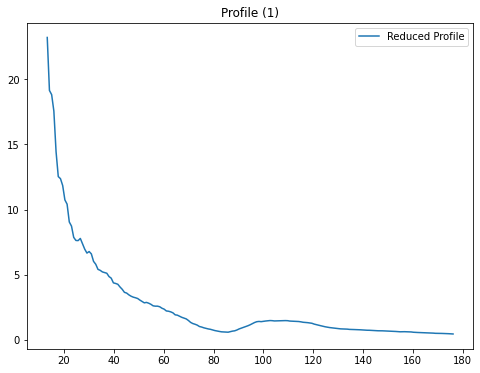

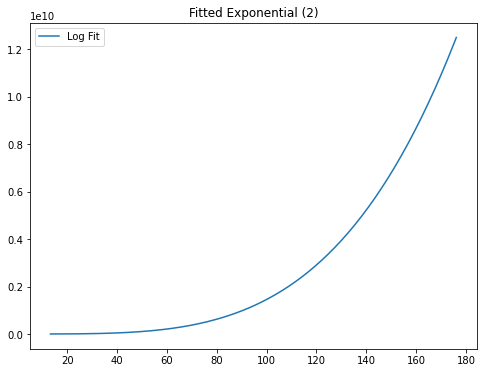

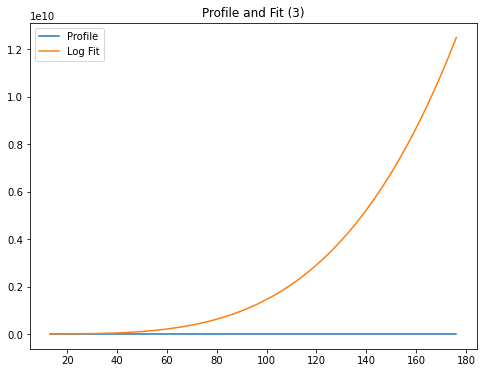

In [40]:
file_dict, b = MakeDict(data_frame=False)
slices = 36
test_file = file_dict['Full File Name'][4]
test_azimuth, center = AzimuthSweep(test_file, 6)
log_Subtraction(test_azimuth, center)